# 6/22
## 데이터 로드 및 전처리

In [1]:
# 데이터 로드 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

df_order = pd.read_csv('orders.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object'})
df_item = pd.read_csv('order_items.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object', 'product_id' : 'object'})

In [2]:
# df_order와 df_item merge
df_merged = pd.merge(left=df_order, right=df_item, on='order_id')
# df_merged의 중복 여부 확인
print(df_merged.size)
print(df_merged.drop_duplicates().size)
# 중복 열 없음.

3437233
3437233


In [3]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180907 entries, 0 to 180906
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           180907 non-null  object 
 1   user_id_x          180907 non-null  object 
 2   status_x           180907 non-null  object 
 3   gender             180907 non-null  object 
 4   created_at_x       180907 non-null  object 
 5   returned_at_x      17991 non-null   object 
 6   shipped_at_x       117220 non-null  object 
 7   delivered_at_x     63061 non-null   object 
 8   num_of_item        180907 non-null  int64  
 9   id                 180907 non-null  int64  
 10  user_id_y          180907 non-null  object 
 11  product_id         180907 non-null  object 
 12  inventory_item_id  180907 non-null  int64  
 13  status_y           180907 non-null  object 
 14  created_at_y       180907 non-null  object 
 15  shipped_at_y       117220 non-null  object 
 16  de

## 2024년 3월과 5월의 매출 성장 요인

### 3월 상품 Segment

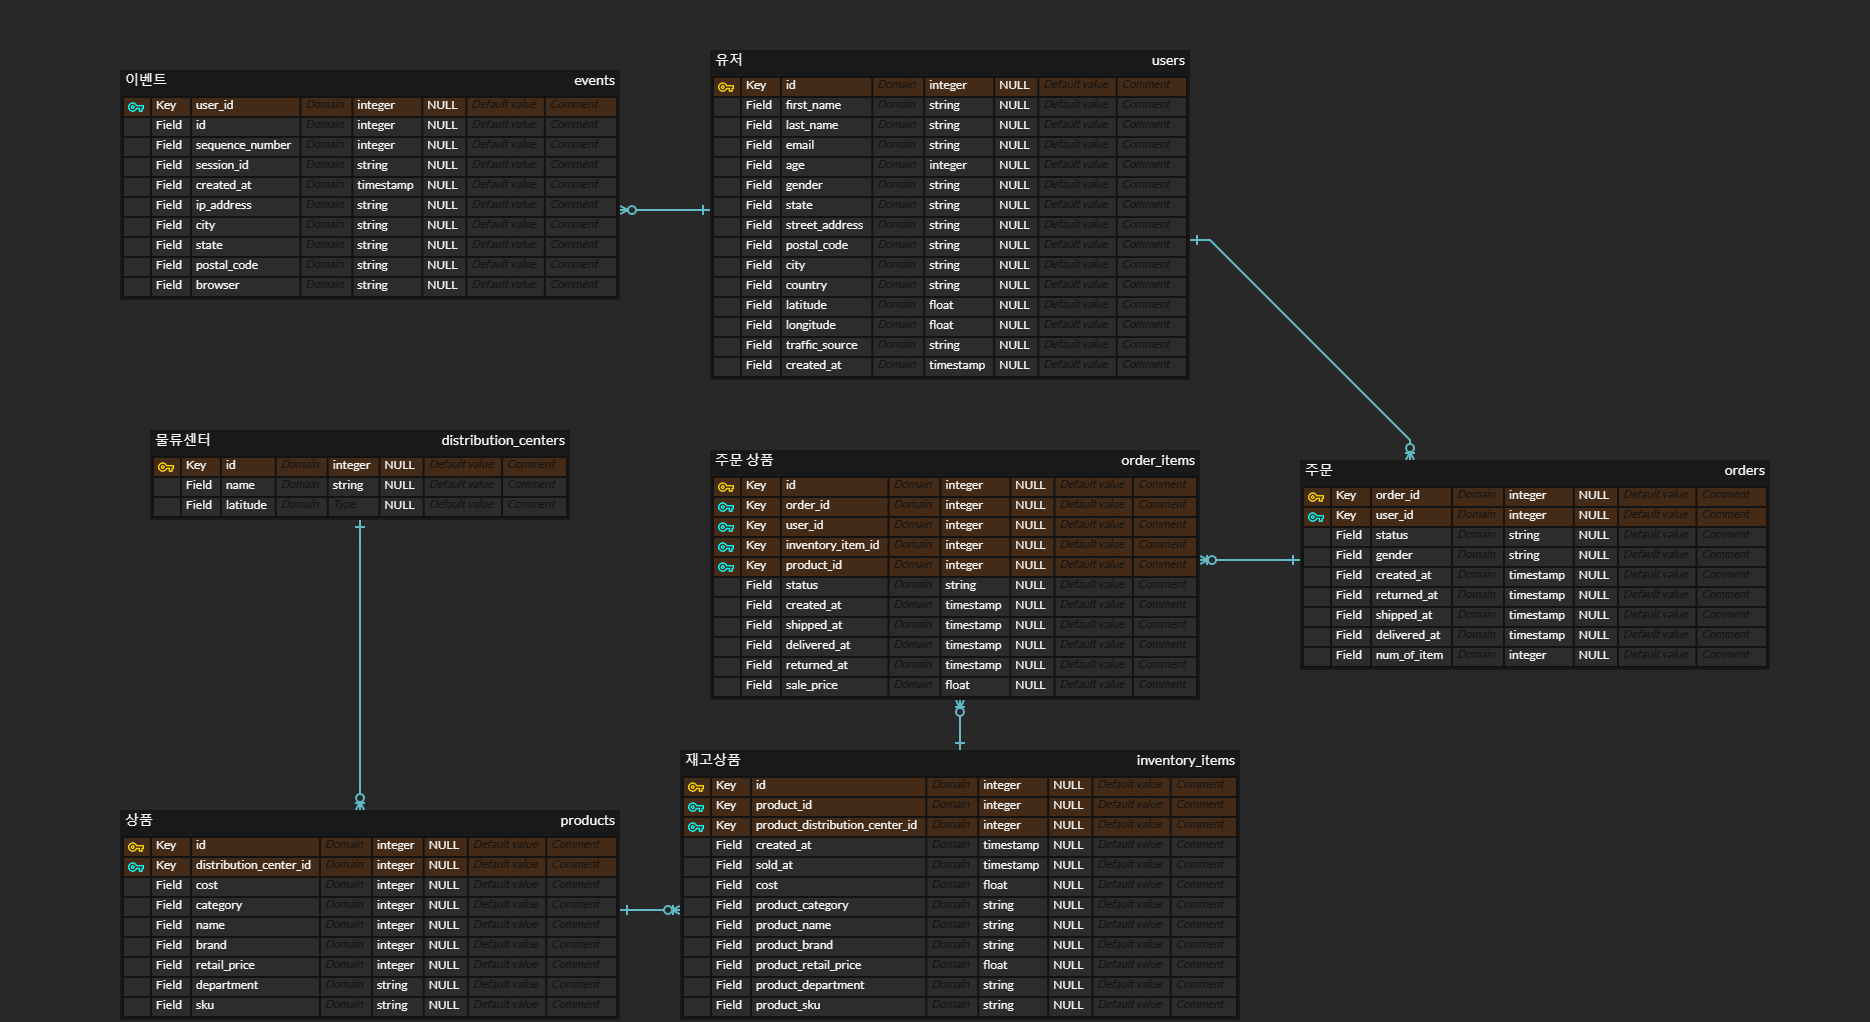

- product DB와 product_id로 JOIN이 가능하다.
- ERD 상 분석할만한 컬럼은 (cost, category, brand, retail_price, department)로 보인다.

In [4]:
df_product = pd.read_csv("products.csv", dtype={'id' : 'object'})
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29120 entries, 0 to 29119
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29120 non-null  object 
 1   cost                    29120 non-null  float64
 2   category                29120 non-null  object 
 3   name                    29118 non-null  object 
 4   brand                   29096 non-null  object 
 5   retail_price            29120 non-null  float64
 6   department              29120 non-null  object 
 7   sku                     29120 non-null  object 
 8   distribution_center_id  29120 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 2.0+ MB


In [5]:
df_merged = pd.merge(left = df_merged, right = df_product, left_on='product_id', right_on='id', how='left')
temp = df_merged.loc[(~df_merged['status_y'].isin(['Cancelled','Returned']))].copy() 

# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)

temp0 = temp
temp = temp.loc[(temp['created_at_x'] >= '2024-01-01')].copy()

C:\Users\no1\AppData\Local\Temp\ipykernel_20872\795345215.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])


In [6]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41253 entries, 13707 to 180905
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                41253 non-null  object        
 1   user_id_x               41253 non-null  object        
 2   status_x                41253 non-null  object        
 3   gender                  41253 non-null  object        
 4   created_at_x            41253 non-null  object        
 5   returned_at_x           0 non-null      object        
 6   shipped_at_x            30289 non-null  object        
 7   delivered_at_x          13756 non-null  object        
 8   num_of_item             41253 non-null  int64         
 9   id_x                    41253 non-null  int64         
 10  user_id_y               41253 non-null  object        
 11  product_id              41253 non-null  object        
 12  inventory_item_id       41253 non-null  int64 

In [7]:
# 3월 주문 데이터 조회 (주수 9 - 13)
temp1 = temp.loc[temp['week'].isin(range(8,16))]
temp1

order_id user_id_x  status_x gender             created_at_x  \
13724        99        95  Complete      F  2024-03-21 12:02:00 UTC   
13769       412       372  Complete      F  2024-03-16 01:01:00 UTC   
13779       477       421  Complete      F  2024-03-01 03:53:00 UTC   
13780       477       421  Complete      F  2024-03-01 03:53:00 UTC   
13796       535       462  Complete      F  2024-03-30 11:24:00 UTC   
...         ...       ...       ...    ...                      ...   
180899   124748     99975   Shipped      M  2024-03-21 16:00:00 UTC   
180900   124748     99975   Shipped      M  2024-03-21 16:00:00 UTC   
180903   124772     99999   Shipped      M  2024-03-11 07:06:00 UTC   
180904   124772     99999   Shipped      M  2024-03-11 07:06:00 UTC   
180905   124772     99999   Shipped      M  2024-03-11 07:06:00 UTC   

       returned_at_x             shipped_at_x           delivered_at_x  \
13724            NaN  2024-03-23 23:11:00 UTC  2024-03-26 17:56:00 UTC   
13769            NaN  2024-03-18 20:05:00 UTC  2024-03-22 03:45:00 UTC   
13779            NaN  2024-03-02 18:31:00 UTC  2024-03-04 11:20:00 UTC   
13780            NaN  2024-03-02 18:31:00 UTC  2024-03-04 11:20:00 UTC   
13796            NaN  2024-04-01 23:41:00 UTC  2024-04-06 20:16:00 UTC   
...              ...                      ...                      ...   
180899           NaN  2024-03-23 16:40:00 UTC                      NaN   
180900           NaN  2024-03-23 16:40:00 UTC                      NaN   
180903           NaN  2024-03-14 06:16:00 UTC                      NaN   
180904           NaN  2024-03-14 06:16:00 UTC                      NaN   
180905           NaN  2024-03-14 06:16:00 UTC                      NaN   

        num_of_item    id_x  ...       date                time  year month  \
13724             1     148  ... 2024-03-21 2024-06-27 12:02:00  2024     3   
13769             1     590  ... 2024-03-16 2024-06-27 01:01:00  2024     3   
13779             2     670  ... 2024-03-01 2024-06-27 03:53:00  2024     3   
13780             2     671  ... 2024-03-01 2024-06-27 03:53:00  2024     3   
13796             1     752  ... 2024-03-30 2024-06-27 11:24:00  2024     3   
...             ...     ...  ...        ...                 ...   ...   ...   
180899            4  180865  ... 2024-03-21 2024-06-27 16:00:00  2024     3   
180900            4  180866  ... 2024-03-21 2024-06-27 16:00:00  2024     3   
180903            3  180902  ... 2024-03-11 2024-06-27 07:06:00  2024     3   
180904            3  180903  ... 2024-03-11 2024-06-27 07:06:00  2024     3   
180905            3  180901  ... 2024-03-11 2024-06-27 07:06:00  2024     3   

       day hour min sec  week quarter  
13724   21   12   2   0    12       1  
13769   16    1   1   0    11       1  
13779    1    3  53   0     9       1  
13780    1    3  53   0     9       1  
13796   30   11  24   0    13       1  
...     ..  ...  ..  ..   ...     ...  
180899  21   16   0   0    12       1  
180900  21   16   0   0    12       1  
180903  11    7   6   0    11       1  
180904  11    7   6   0    11       1  
180905  11    7   6   0    11       1  

[12084 rows x 38 columns]

In [8]:
temp1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12084 entries, 13724 to 180905
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                12084 non-null  object        
 1   user_id_x               12084 non-null  object        
 2   status_x                12084 non-null  object        
 3   gender                  12084 non-null  object        
 4   created_at_x            12084 non-null  object        
 5   returned_at_x           0 non-null      object        
 6   shipped_at_x            8911 non-null   object        
 7   delivered_at_x          4053 non-null   object        
 8   num_of_item             12084 non-null  int64         
 9   id_x                    12084 non-null  int64         
 10  user_id_y               12084 non-null  object        
 11  product_id              12084 non-null  object        
 12  inventory_item_id       12084 non-null  int64 

#### department 분석

In [9]:
temp1['department'].unique()
# department는 Women, Men으로 구분된다.

array(['Women', 'Men'], dtype=object)

In [10]:
# Women, Men의 매출 비율
temp1.groupby(['department'])['sale_price'].sum() / temp1['sale_price'].sum() * 100
# Women은 48.6%, Men은 51.4%이다.

department
Men      51.363829
Women    48.636171
Name: sale_price, dtype: float64

In [11]:
# Department별 매출 비율 변화
temp2 = temp1.groupby(['week','department'])['sale_price'].sum().reset_index(name='sale_price')
px.line(temp2, x='week', y='sale_price', color='department')
# 주수 범위 [9, 14] 구간을 살펴보면 다음과 같다.
# Women은 9주까진 Men보다 더 많은 매출을 기록했다.
# 그러나 10주에서 Men의 매출이 Women의 매출을 크게 상회했다. (+12.3K)
# 11주에 Women의 매출도 뚜렷하게 증가하여 Men의 매출과 엇비슷해졌다. (-0.2K)
# 그러나 13주부터 다시 Women의 매출이 감소하여 차이가 증가했다. 
# 14주에는 이 차이가 더 확대되었다.

In [12]:
# 주수별 Women과 Men의 매출 차이 시각화
# Men 매출에서 Women 매출을 뺀 값으로 시각화
temp2 = temp1.groupby(['week','department'])['sale_price'].sum().unstack()
temp2['deviation'] = temp2['Men'] - temp2['Women']
temp2['total'] = temp2['Men'] + temp2['Women']
fig = px.line(temp2)
print(temp2.corr())
# 전체 매출과의 상관계수는 Men이 Women보다 0.007만큼  높다.
fig.show()
# [9, 14] 구간 동안 10, 13, 14에서 Men과 Women의 매출 편차가 크게 늘어났다. ([12.2K, 3.8K, 7.8K])
# 전체 매출이 증가하는 구간에서, Men이 Women에 비해 꾸준히 더 많은 매출을 기록했으므로, 매출 상승의 요인일 수 있다.

department       Men     Women  deviation     total
department                                         
Men         1.000000  0.408763   0.558043  0.843172
Women       0.408763  1.000000  -0.529213  0.835333
deviation   0.558043 -0.529213   1.000000  0.024384
total       0.843172  0.835333   0.024384  1.000000


In [13]:
# 주수별 Men, Women의 매출 비중
temp2 = temp1.groupby(['week','department'])['sale_price'].sum().unstack()
temp2['total'] = temp2['Men'] + temp2['Women']
temp2['Men'] = temp2['Men'] / temp2['total']
temp2['Women'] = temp2['Women'] / temp2['total']
px.line(temp2[['Men']])
# 전체 매출 대비 Men의 비중을 나타낸 시각화이다.
# Women의 비중은 1 - Men의 비중이다.
# Men의 비중은 49% 이하로 내려간 적이 없다.
# 10주에 57%까지 상승했다.

In [14]:
# Men의 매출 성장률이 전체 매출 성장률에 얼마나 기여했을까?
# Men과 전체 매출의 해당 주수의 순 성장률을 살펴보자.
# 순 성장률이란 이전 주와 비교하여 해당 주에 얼마나 성장했는지를 나타낸 것이다.
temp2 = temp1.groupby(['week','department'])['sale_price'].sum().unstack()
temp2['men_growth'] = (temp2['Men'] - temp2['Men'].shift(1)) / temp2['Men'].shift(1) * 100
temp2['women_growth'] = (temp2['Women'] - temp2['Women'].shift(1)) / temp2['Women'].shift(1) * 100
temp2['total'] = temp2['Men'] + temp2['Women']
temp2['total_growth'] = (temp2['total'] - temp2['total'].shift(1)) / temp2['total'].shift(1) * 100
px.line(temp2[['men_growth','women_growth','total_growth']])

In [15]:
# 전체 매출을 기준으로, men과 women의 주수 순 성장 매출이 어떤 패턴을 보이는지 시각화하기
temp2 = temp1.groupby(['week','department'])['sale_price'].sum().unstack()
temp2['men_growth'] = (temp2['Men'] - temp2['Men'].shift(1))
temp2['women_growth'] = (temp2['Women'] - temp2['Women'].shift(1))
temp2['total'] = temp2['Men'] + temp2['Women']
temp2['total_growth'] = (temp2['total'] - temp2['total'].shift(1))

# temp2['men_growth'] = temp2['men_growth'] - temp2['total_growth']
# temp2['women_growth'] = temp2['women_growth'] - temp2['total_growth']
px.line(temp2[['men_growth','women_growth']])

# 해당 주의 성장 매출을 0으로 보았을 때, Men과 Women의 성장 매출을 나타낸 시각화이다.
# men이 전체 매출보다 더 높은 성장을 보였던 주수는 [9, 10, 13]이다.
# women이 전체 매출보다 더 높은 성장을 보였던 주수는 [9, 11]이다.
# 그러므로 해당 구간에서 men이 women보다 전체 매출 성장에 더 많이 기여했다고 할 수 있다.

In [16]:
temp2

department           Men         Women    men_growth  women_growth  \
week                                                                 
8           41527.180041  43495.060050           NaN           NaN   
9           38392.890019  40069.040082  -3134.290022  -3426.019969   
10          48719.860065  36458.920045  10326.970046  -3610.120037   
11          44678.840009  44416.840041  -4041.020056   7957.919996   
12          47537.780077  49154.050073   2858.940067   4737.210032   
13          47982.250019  44129.810063    444.469943  -5024.240010   
14          51583.379980  43788.340121   3601.129961   -341.469942   
15          52329.160019  51444.450042    745.780039   7656.109921   

department          total  total_growth  
week                                     
8            85022.240091           NaN  
9            78461.930100  -6560.309991  
10           85178.780110   6716.850009  
11           89095.680050   3916.899940  
12           96691.830150   7596.150100  
13           92112.060082  -4579.770067  
14           95371.720101   3259.660019  
15          103773.610061   8401.889960

In [17]:
# total_growth를 기준으로, men과 women의 주수 순 성장률이 어떤 패턴을 보였는지 시각화하자.
temp2 = temp1.groupby(['week','department'])['sale_price'].sum().unstack()
temp2['men_growth'] = (temp2['Men'] - temp2['Men'].shift(1)) / temp2['Men'].shift(1) * 100
temp2['women_growth'] = (temp2['Women'] - temp2['Women'].shift(1)) / temp2['Women'].shift(1) * 100
temp2['total'] = temp2['Men'] + temp2['Women']
temp2['total_growth'] = (temp2['total'] - temp2['total'].shift(1)) / temp2['total'].shift(1) * 100

temp2['men_growth'] = temp2['men_growth'] - temp2['total_growth']
temp2['women_growth'] = temp2['women_growth'] - temp2['total_growth']
px.line(temp2[['men_growth','women_growth']])
# men이 전체 매출보다 더 높은 성장률을 보였던 주수는 [10, 13, 14]이다.
# women이 전체 매출보다 더 높은 성장률을 보였던 주수는 [11]이다.
# 주수[9, 12]는 셋 모두 거의 동일한 성장률을 보였다.
# 그러므로 해당 구간에서 men이 women보다 전체 매출 성장에 더 많이 기여했다고 할 수 있다.

In [18]:
# 전체 기간 내 Department 비율
print("전 기간 department 비율 : \n",temp0.groupby('department').size() / temp0.shape[0])
# 해당 구간 내 Department 비율
print(" 해당 구간 department 비율 : \n",temp1.groupby('department').size() / temp1.shape[0])

# 전체 기간 내 Department 매출 비율
print("전 기간 department 매출 비율 : \n", temp0.groupby('department')['sale_price'].sum() / temp0['sale_price'].sum())

# 해당 구간 내 Department 매출 비율
print("해당 구간 department 매출 비율 : \n", temp1.groupby('department')['sale_price'].sum() / temp1['sale_price'].sum())

전 기간 department 비율 : 
 department
Men      0.498998
Women    0.501002
dtype: float64
 해당 구간 department 비율 : 
 department
Men      0.490152
Women    0.509848
dtype: float64
전 기간 department 매출 비율 : 
 department
Men      0.527222
Women    0.472778
Name: sale_price, dtype: float64
해당 구간 department 매출 비율 : 
 department
Men      0.513638
Women    0.486362
Name: sale_price, dtype: float64


In [19]:
# department 비율 시각화
temp2 = temp0.groupby(['date','department'])['sale_price'].sum().reset_index()
px.line(temp2, x='date', y='sale_price', color='department')

In [29]:
(((temp0['gender'] == 'F') & (temp0['department'] == 'Women')) | ((temp0['gender'] == 'M') & (temp0['department'] == 'Men'))).value_counts()

True    135680
Name: count, dtype: int64

In [28]:
temp0['department']

13706     Women
13707     Women
13708     Women
13709     Women
13710     Women
          ...  
180902      Men
180903      Men
180904      Men
180905      Men
180906      Men
Name: department, Length: 135680, dtype: object